In [94]:
import pandas as pd
import numpy as np
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

import seaborn as sns
sns.set_style('white')

#### corin's attempts to fit random forest to data

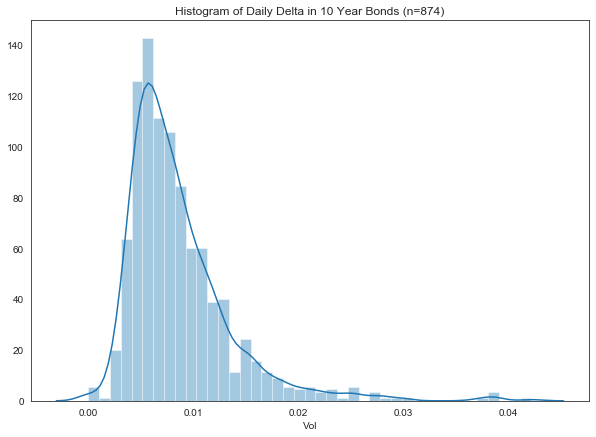

In [2]:
bonds_10 = pd.read_csv('../bonds/adjusted^TNX.csv')
bonds_10['Vol'] = (bonds_10['High'] - bonds_10['Low']) / (bonds_10['High'] + bonds_10['Low'])
#print(bonds_10.head(10))

bonds_30 = pd.read_csv('../bonds/adjusted^TYX.csv')
bonds_30['Vol'] = (bonds_30['High'] - bonds_30['Low']) / (bonds_30['High'] + bonds_30['Low'])
#print(bonds_30.head(10))

fig = plt.figure(figsize=(10,7))
sns.distplot(bonds_10['Vol'])
plt.title(f'Histogram of Daily Delta in 10 Year Bonds (n={len(bonds_10)})')

plt.show()

In [82]:
stocks_cn = pd.read_csv('../stocks/log_adj_chinese_combo.csv')
stocks_cn['Date'] = stocks_cn['date']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 34 columns):
Unnamed: 0                 1001 non-null float64
Unnamed: 1                 1001 non-null float64
Unnamed: 2                 1001 non-null float64
num_words                  1001 non-null float64
num_hashtags               1001 non-null float64
is_retweet                 1001 non-null int64
favorite_count             1001 non-null int64
retweet_count              1001 non-null int64
num_mentions               1001 non-null float64
keyword_China              1001 non-null float64
keyword_Russia             1001 non-null float64
keyword_Mexico             1001 non-null float64
keyword_Canada             1001 non-null float64
keyword_Korea              1001 non-null float64
keyword_Clinton            1001 non-null float64
keyword_Democrats          1001 non-null float64
keyword_Republicans        1001 non-null float64
keyword_himself            1001 non-null float64
keyword_family   

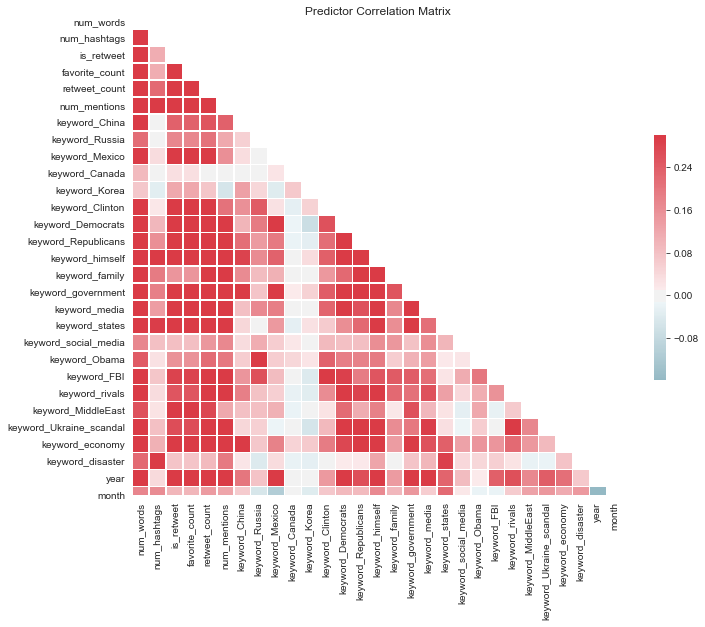

In [4]:
predictors = pd.read_csv('../tweets/cleaned_tweets_by_day')
print(predictors.info())

#### so we can quickly pull out the desired columns later
pred_cols = predictors.columns.values
pred_cols = list(filter(lambda a: not re.match("Unnamed", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("Date", a), pred_cols))
#pred_cols = list(filter(lambda a: not re.match("year", a), pred_cols))
#pred_cols = list(filter(lambda a: not re.match("month", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("day", a), pred_cols))


if 0:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7))

    for ax in np.ravel(axes):
        ax.get_yaxis().set_visible(False)

    sns.distplot(predictors['num_hashtags'], ax=axes[0][0])
    sns.distplot(predictors['retweet_count'], ax=axes[0][1])
    sns.distplot(predictors['favorite_count'], ax=axes[0][2])
    sns.distplot(predictors['keyword_himself'], ax=axes[1][0])
    sns.distplot(predictors['keyword_economy'], ax=axes[1][1])
    sns.distplot(predictors['num_mentions'], ax=axes[1][2])
    fig.suptitle("Histograms of Various Response Variables", fontsize=14)
    plt.tight_layout
    plt.show()

#print("average daily keywords:\n")
#for keyword in list(filter(lambda a: re.match("keyword", a), pred_cols)):
#    print(f"{keyword:30s}: {np.mean(predictors[keyword]):.3f}")

corr = predictors[pred_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Predictor Correlation Matrix')
plt.show()

In [17]:
import copy
pred_bonds_10 = pd.merge(left=bonds_10, right=predictors, on='Date') # default is INNER join which is what we want

def add_lookback_predictors(df, columns, num_days=10):
    df.sort_values(by=['Date'])
    new_cols = copy.deepcopy(columns)
    
    for idx, row in df.iterrows():
        if idx < num_days:
            continue
        for col in columns:
            for day in range(1,num_days+1):
                new_cols.append(f"{col}_{day}")
                df.loc[idx, f"{col}_{day}"] = df.loc[idx-day, col]
    
    return list(set(new_cols)) # need unique
        
pred_cols2 = add_lookback_predictors(pred_bonds_10, pred_cols, num_days=10)
print(pred_cols2[-20:])
pred_bonds_10.info()

['is_retweet_10', 'year_3', 'num_hashtags_5', 'keyword_FBI_3', 'keyword_states', 'keyword_rivals_1', 'keyword_Republicans_10', 'is_retweet_1', 'num_words_9', 'num_words_1', 'keyword_Russia_9', 'keyword_Clinton_1', 'keyword_media_5', 'keyword_Obama_3', 'keyword_China_7', 'num_hashtags_4', 'num_words_8', 'keyword_Ukraine_scandal_5', 'keyword_Republicans_1', 'keyword_Mexico_4']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 0 to 834
Columns: 332 entries, Unnamed: 0_x to month_10
dtypes: float64(326), int64(5), object(1)
memory usage: 2.2+ MB


In [26]:
### now these have the same indices!

print(len(pred_bonds_10))

full_test = pred_bonds_10[669:835]
full_train = pred_bonds_10[10:668]

Xt = full_test[pred_cols2].to_numpy()
yt = full_test['Vol'].to_numpy()

X = full_train[pred_cols2].to_numpy()
y = full_train['Vol'].to_numpy()



835


In [22]:
rf_b = RandomForestRegressor(n_estimators=50, max_features=0.33, max_depth=5, min_samples_leaf=5, random_state=42).fit(X, y)
print(f"train is {rf_b.score(X,y):.3f}")
print(f"test is  {rf_b.score(Xt,yt):.3f}")

train is 0.423
test is  -0.801


In [85]:
pred_stocks_cn = pd.merge(left=stocks_cn, right=predictors, on='Date') # default is INNER join which is what we want
#### now these have the same indices!

pred_cols3 = add_lookback_predictors(pred_stocks_cn, pred_cols, num_days=10)

print(len(pred_stocks_cn))

pred_stocks_cn.sort_values(by=['Date'])

full_test_s = pred_stocks_cn[555:693]
full_train_s = pred_stocks_cn[10:554]

Xt2 = full_test_s[pred_cols3].to_numpy()
yt2 = full_test_s['combined'].to_numpy()

X2 = full_train_s[pred_cols3].to_numpy()
y2 = full_train_s['combined'].to_numpy()

693


In [27]:
rf_s = RandomForestRegressor(n_estimators=50,max_features=0.33, max_depth=5, min_samples_leaf=5, random_state=42).fit(X, y)
print(f"train is {rf_s.score(X,y):.3f}")
print(f"test is  {rf_s.score(Xt,yt):.3f}")
# wow!

train is 0.960
test is  -4.433


In [19]:
import tensorflow as tf

print(tf.__version__)  # You should see a 2.0.0 here!

2.0.0


In [27]:
print(len(pred_cols2))

319


In [74]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
dropout_c = 0.2

model.add(layers.Dense(64, activation='relu', input_shape=(319,)))
model.add(layers.Dropout(dropout_c))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(dropout_c))
model.add(layers.Dense(16, activation='softmax'))
model.add(layers.Dense(1, activation='linear'))


In [75]:
model.compile(loss='mean_absolute_error', optimizer='adam')
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                20480     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 17        
Total params: 25,697
Trainable params: 25,697
Non-trainable params: 0
__________________________________________________

In [86]:
model.fit(X2, y2, epochs=50, batch_size=32, validation_split=0.2)

Train on 435 samples, validate on 109 samples
Epoch 1/50
435/435 [==============================] - 0s 332us/sample - loss: 0.6314 - val_loss: 0.4010
Epoch 2/50
435/435 [==============================] - 0s 252us/sample - loss: 0.6312 - val_loss: 0.4012
Epoch 3/50
435/435 [==============================] - 0s 239us/sample - loss: 0.6312 - val_loss: 0.4017
Epoch 4/50
435/435 [==============================] - 0s 223us/sample - loss: 0.6312 - val_loss: 0.4018
Epoch 5/50
435/435 [==============================] - 0s 223us/sample - loss: 0.6308 - val_loss: 0.4016
Epoch 6/50
435/435 [==============================] - 0s 221us/sample - loss: 0.6311 - val_loss: 0.4015
Epoch 7/50
435/435 [==============================] - 0s 233us/sample - loss: 0.6311 - val_loss: 0.4020
Epoch 8/50
435/435 [==============================] - 0s 237us/sample - loss: 0.6318 - val_loss: 0.4017
Epoch 9/50
435/435 [==============================] - 0s 263us/sample - loss: 0.6312 - val_loss: 0.4015
Epoch 10/50
435/43

In [88]:
loss = model.evaluate(Xt, yt, verbose=0)
print(loss)

0.08871792283761933


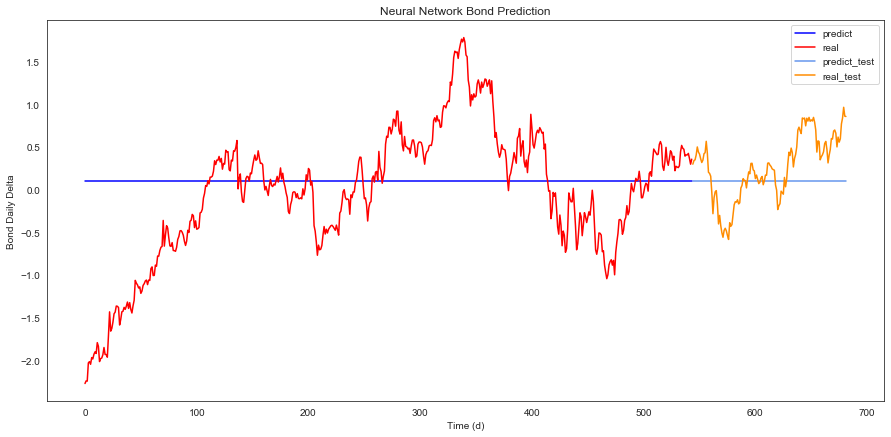

In [93]:
fig = plt.figure(figsize=(15,7))

pred_y = model.predict(X2, verbose=0)
pred_yt = model.predict(Xt2, verbose=0)

plt.title('Neural Network Bond Prediction')
plt.ylabel('Bond Daily Delta')
plt.xlabel('Time (d)')

plt.plot(range(len(y2)), pred_y, c='b', label='predict')
plt.plot(range(len(y2)), y2, c='r', label='real')
plt.plot(range(len(y2),len(yt2)+len(y2)), pred_yt, c='cornflowerblue', label='predict_test')
plt.plot(range(len(y2),len(yt2)+len(y2)), yt2, c='darkorange', label='real_test')

plt.legend(loc='best')
plt.show()